In [1]:
from biozorromodel import BioZorro
from datasets import load_from_disk
from encoders import BioZorroCollator

In [2]:
lm_datasets = load_from_disk('data/filtered_protein_mrna_genes')

In [3]:
lm_datasets = lm_datasets.rename_column('total_index','expression_index')
lm_datasets = lm_datasets.rename_column('total_data','expression_data')


In [4]:
#keep =  ['spliced_index', 'unspliced_index', 'spliced_data', 'unspliced_data']
keep = ['expression_index','expression_data','spliced_index', 'unspliced_index', 'spliced_data', 'unspliced_data']
remove = list()
for key in lm_datasets.features.keys():
    if key not in keep:
        remove.append(key)
lm_datasets = lm_datasets.remove_columns(remove)

In [130]:
from torch.utils.data import DataLoader
default_data_collator = BioZorroCollator(pad_len=512, pad_token=0)
dataloader = DataLoader(lm_datasets.with_format('torch'), shuffle=True, collate_fn=default_data_collator, batch_size=4,)

In [134]:
batch = next(iter(dataloader))
batch

{'expression_index': tensor([[   9,   29,   34,  ..., 8725, 8740, 8771],
         [  12,  103,  133,  ...,    0,    0,    0],
         [  46,  191,  194,  ...,    0,    0,    0],
         [  12,   29,  134,  ...,    0,    0,    0]]),
 'spliced_index': tensor([[    9,    29,    46,  ..., 16569, 16598, 16649],
         [   12,   103,   358,  ...,     0,     0,     0],
         [   46,   194,   476,  ...,     0,     0,     0],
         [  159,   191,   204,  ...,     0,     0,     0]]),
 'unspliced_index': tensor([[ 34, 120, 158,  ...,   0,   0,   0],
         [133, 158, 231,  ...,   0,   0,   0],
         [191, 426, 501,  ...,   0,   0,   0],
         [ 12,  29, 134,  ...,   0,   0,   0]]),
 'expression_data': tensor([[1., 1., 1.,  ..., 1., 1., 2.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 'spliced_data': tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1

In [57]:
#https://ai.stackexchange.com/questions/28564/how-to-determine-the-embedding-size
import numpy as np
vocab_size = 18817
num_embeddings = int(75.6496 * np.log(vocab_size + 176.623) - 41.4457)
print(num_embeddings)

703


In [74]:
2.5*10**5*256/8

8000000.0

In [62]:
config = {
    "dim": num_embeddings, #hidden size
    "depth": 3, #layers
    "spliced_input_dim": num_embeddings, #embedding_size
    "unspliced_input_dim": num_embeddings,
    "dim_head":64, #don't know, head hidden size?
    "heads": 4, #num heads
    "ff_mult": 4, #Feed forward multiplier
    "num_fusion_tokens": 16,
    "vocab_size": vocab_size
}

model = BioZorro(**config)

In [63]:
for n,p in model.named_parameters():
    if p.requires_grad:
        print(f"{n}:{p.numel()/10**6}")

return_tokens:0.002109
fusion_tokens:0.011248
loss.contrastive_loss.logit_scale:1e-06
attn_pool.norm.gamma:0.000703
attn_pool.to_q.weight:0.179968
attn_pool.to_kv.weight:0.359936
attn_pool.to_out.weight:0.179968
spliced_embedding.gene_encoder.embedding.weight:13.228351
spliced_embedding.gene_encoder.enc_norm.weight:0.000703
spliced_embedding.gene_encoder.enc_norm.bias:0.000703
spliced_embedding.counts_encoder.linear1.weight:0.000703
spliced_embedding.counts_encoder.linear1.bias:0.000703
spliced_embedding.counts_encoder.linear2.weight:0.494209
spliced_embedding.counts_encoder.linear2.bias:0.000703
spliced_embedding.counts_encoder.norm.weight:0.000703
spliced_embedding.counts_encoder.norm.bias:0.000703
unspliced_embedding.gene_encoder.embedding.weight:13.228351
unspliced_embedding.gene_encoder.enc_norm.weight:0.000703
unspliced_embedding.gene_encoder.enc_norm.bias:0.000703
unspliced_embedding.counts_encoder.linear1.weight:0.000703
unspliced_embedding.counts_encoder.linear1.bias:0.000703


In [61]:
outputs = model(**batch)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 703 but got size 128 for tensor number 1 in the list.

In [41]:
outputs

BioZorroPretrainingLossOutput(losses=BioZorroPretrainingLossesCollection(contrastive_loss=tensor(10.3229, grad_fn=<DivBackward0>), fusion_loss_spliced=tensor(2.3723, grad_fn=<DivBackward0>), fusion_loss_unspliced=tensor(3.2532, grad_fn=<DivBackward0>)), spliced_output=None, unspliced_output=None, fusion_output=None)

In [ ]:
outputs.loss.backward()

In [ ]:
import wandb
wandb.init()

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm

epochs=100
optimizer = AdamW(model.parameters(), lr=0.0001)
num_training_steps = epochs * len(dataloader)
progress_bar = tqdm(range(num_training_steps))

#print("Start training: {}".format(strftime("%Y-%m-%d %H:%M:%S", gmtime())))
## Start model training and defining the training loop
model.train()
for epoch in range(epochs):
    for batch in dataloader:
        #batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        optimizer.zero_grad()
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
        wandb.log({"loss":loss.detach().to("cpu")})
    print(f"Epoch {epoch}: loss: {loss.detach()}")
        #
    #if xm.is_master_ordinal(local=False):
    wandb.log({"epoch_loss":loss.detach().to("cpu")})

logger.info("End training: {}".format(strftime("%Y-%m-%d %H:%M:%S", gmtime())))

In [17]:
from collections import defaultdict
import torch
losses = defaultdict(lambda: torch.Tensor([0.0]).to("cpu"))
losses['test']+=torch.Tensor([1.0])

# Scaling law results

In [5]:
import pandas as pd
import numpy as np
nparam = np.array([76.65,38.81,32.5, 26.23,
                   19.94,13.64,10.50,7.35])*10**6
nlayers = np.array([24,16,10,8,6,4,3,2])
sm_loss = { 'fusion_spliced': [0.05217,0.055660,0.05406000, 0.04967,
                               0.0688, 0.0625,0.06375,0.07791],
           'fusion_unspliced':[0.05201,0.055482,0.05395645, 0.04972,
                               0.06859,0.0624,0.06347,0.07738],
           'contrastive_loss':[0.051933,0.05556,0.054283, 0.0499,
                               0.06961,0.0638,0.06341,0.07857]
}
dm_loss = { 'fusion_spliced':[0.002226,0.004596, 0.0047380,0.003942,
                              0.005551,0.005522,0.005401,0.01271],
           'fusion_unspliced':[0.002172,0.0046209,0.0047747,0.004004,
                               0.005403,0.005479,0.005485,0.01249],
           'contrastive_loss':[0.002259,0.004727,0.0048772,0.00414,
                               0.005551,0.005278,0.005551,0.01522]
}

dm_loss=np.array(list(dm_loss.values()))
dm_loss = dm_loss.sum(axis=0)
#dm_loss=dm_loss[:,:-1].sum(axis=0)
sm_loss=np.array(list(sm_loss.values()))
sm_loss = sm_loss.sum(axis=0)
#sm_loss=sm_loss[:,:-1].sum(axis=0)
#nparam=nparam[:-1]
df = pd.DataFrame.from_dict({'dual':dm_loss,
                             'single':sm_loss,
                             'param':nparam})
df_m = pd.DataFrame.from_dict({'dual':dm_loss/dm_loss.mean(),
                               'single':sm_loss/sm_loss.mean(),
                               'param':nparam})
df.to_csv('prelim_scale_data.csv')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f33337f34d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  
/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f33317b8550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  
/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f33317b8c10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  
/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f33317379d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
/shared/miniconda3/lib/pyth

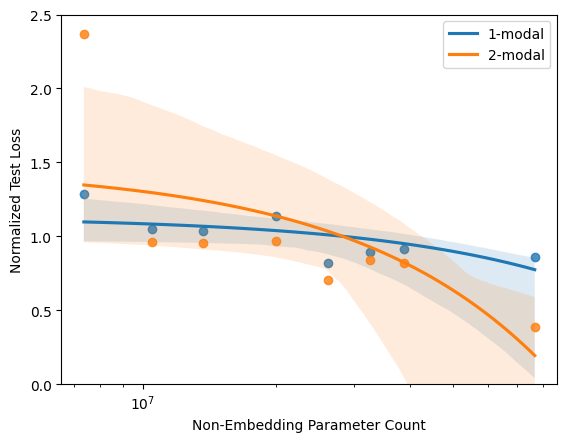

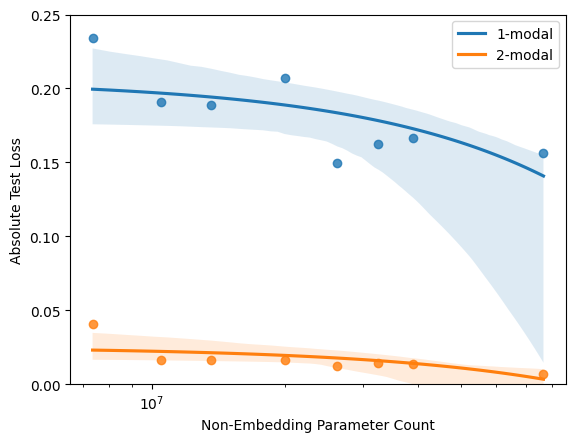

In [4]:
sm_loss_ = sm_loss
dm_loss_ = dm_loss
nparam_ = nparam
nlayers_ = nlayers
plt.clf()
plt.figure(1)
#plt.plot(nparam_,np.array(sm_loss_)/sm_loss_.mean(),'o-',
#         nparam_,np.array(dm_loss_)/dm_loss_.mean(),'x-')
sns.regplot(df_m, x='param',y='single')
sns.regplot(df_m, x='param',y='dual')
plt.xscale('log')
#plt.xlim([9*10**6,10**8])
plt.ylim([0,2.5])
plt.xlabel('Non-Embedding Parameter Count')
plt.ylabel('Normalized Test Loss')
plt.legend(['_nolegend_',"1-modal",'_nolegend_','_nolegend_',"2-modal"]) 
plt.figure(2)
#plt.plot(nparam_,np.array(sm_loss_),'o-',
#         nparam_,np.array(dm_loss_),'x-')
sns.regplot(df, x='param',y='single')
sns.regplot(df, x='param',y='dual')
plt.xscale('log')
plt.ylim([0,0.25])

#plt.xlim([5*10**6,10**8])
plt.xlabel('Non-Embedding Parameter Count')
plt.ylabel('Absolute Test Loss')
plt.legend(['_nolegend_',"1-modal",'_nolegend_','_nolegend_',"2-modal"]) 
#, "1-modal", "2-modal"])

In [11]:
from safetensors.torch import load_model
import json
import os
import torch

In [8]:
from multizorromodel import BioZorro

In [9]:
output_dir = 'training_output_20_46_19_10_2023'
with open(os.path.join(output_dir,'model_config.json'),'r') as f:
    model_config = json.load(f)

In [16]:
model = BioZorro(**model_config)
model.eval()
with torch.no_grad():
    print(model(**batch))

BioZorroPretrainingLossOutput(losses=BioZorroPretrainingLossesCollection(contrastive_loss_spliced_unspliced=tensor(3.5484), contrastive_loss_spliced_expression=tensor(1.9987), contrastive_loss_unspliced_expression=tensor(2.7059), fusion_loss_spliced=tensor(5.4788), fusion_loss_unspliced=tensor(6.1860), fusion_loss_expression=tensor(5.3437)), spliced_output=None, unspliced_output=None, expression_output=None, fusion_output=None)


In [20]:
load_model(model,os.path.join(output_dir,'model.safetensors'))
with torch.no_grad():
    print(model(**batch))

BioZorroPretrainingLossOutput(losses=BioZorroPretrainingLossesCollection(contrastive_loss_spliced_unspliced=tensor(0.8836), contrastive_loss_spliced_expression=tensor(0.8539), contrastive_loss_unspliced_expression=tensor(0.8359), fusion_loss_spliced=tensor(1.0182), fusion_loss_unspliced=tensor(1.0002), fusion_loss_expression=tensor(0.9524)), spliced_output=None, unspliced_output=None, expression_output=None, fusion_output=None)


In [151]:
token_types = torch.tensor(list((
    *((0,) * 512),
    *((1,) * 512),
    *((2,) * 512),
)), dtype=torch.long)

In [152]:
token_types.shape

torch.Size([1536])

In [153]:
from einops import rearrange

In [154]:
token_types_attend_from = rearrange(token_types, 'i -> i 1')
token_types_attend_to = rearrange(token_types, 'j -> 1 j')

In [155]:
zorro_mask = token_types_attend_from == token_types_attend_to

In [156]:
zorro_mask = zorro_mask | (token_types_attend_from == 1)

In [157]:
zorro_mask.shape

torch.Size([1536, 1536])

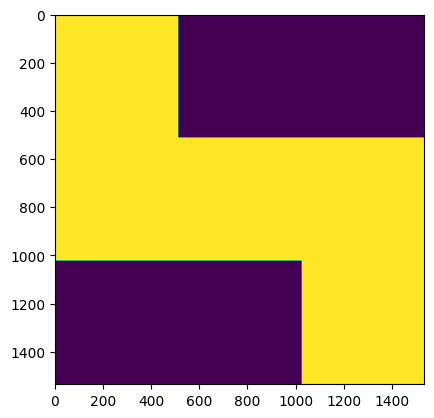

In [158]:
import matplotlib.pyplot as plt
plt.imshow(zorro_mask)

In [170]:
from einops import pack,repeat
tokens, ps = pack((
    batch['expression_index'] == 0,
    batch['spliced_index'] == 0,
    batch['unspliced_index'] == 0,
   #Also need fusion tokens here torch.tensor((True,) * 16),
    ), 'b *')
attn_mask = repeat(tokens, 'b i -> b i j', j=tokens.shape[-1])

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 4 but got size 16 for tensor number 3 in the list.

In [172]:
attn_mask.unsqueeze(1).shape

torch.Size([4, 1, 1536, 1536])

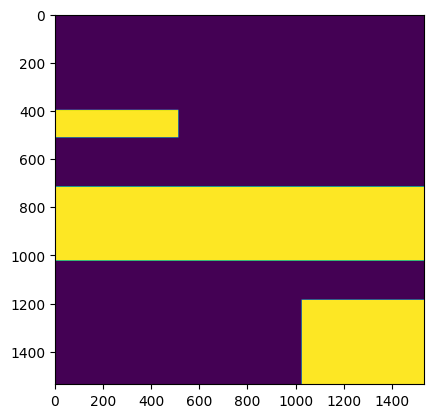

In [165]:
plt.imshow(attn_mask[2,:,:] * zorro_mask)